<h1><center>Projet Deep Learning: <br/> Analyse de Sentiment</center></h1>
<br/>
<div class='text-danger'><center> Objectif : Déterminer les sentiment d'un tweet</center></div>
<div class='text-danger'><center> Dataset : Sentiment140</center></div>

## Préparation du Dataset

### Importation des bibliothèques nécessaires à notre projet

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
import re
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import opendatasets as od
import codecs
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

c:\Users\corbe\miniconda3\envs\sentiment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\corbe\miniconda3\envs\sentiment\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\corbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Initialisation du Dataset

In [3]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")

Skipping, found downloaded files in ".\sentiment140" (use force=True to force download)


In [4]:
file = ('sentiment140/training.1600000.processed.noemoticon.csv')
Data_set = pd.read_csv(file, delimiter=',', encoding='latin1')
  
Data_set.head()



,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Comme nous pouvons le voir, notre dataset n'a pas des noms de colonnes, on va donc en ajouter.



In [5]:
Data_set.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
Data_set.head()

,sentiment,id,date,query,user_id,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Nous n'avons pas besoin des colonnes 'id', 'date', 'query' et 'user_id' puisque nous allons traiter le texte et les sentiments seulement, indépendamment des autres données.

In [6]:
Data_set = Data_set.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [7]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
Data_set.sentiment = Data_set.sentiment.apply(lambda x: label_decoder(x))
Data_set.head()

,sentiment,text
0,Negative,is upset that he can't update his Facebook by ...
1,Negative,@Kenichan I dived many times for the ball. Man...
2,Negative,my whole body feels itchy and like its on fire
3,Negative,"@nationwideclass no, it's not behaving at all...."
4,Negative,@Kwesidei not the whole crew


Regardons la répartition des données du dataset pour être sûr d'avoir bien une bon nombre de chaques classes (ici sentiments négatifs et sentiments positifs).

Text(0.5, 1.0, 'Distribution des données des sentiments')

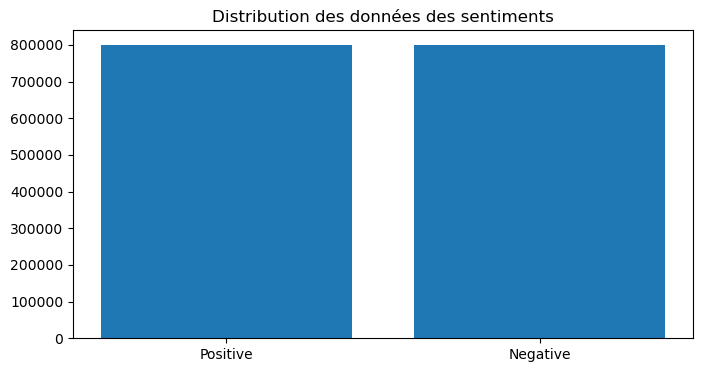

In [8]:
val_count = Data_set.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Distribution des données des sentiments")

On peut voir qu'on a approximativement 50% pour chaque classes, ce qui est parfait.
Voyons maintenant quelques données aléatoires de notre dataset.

In [9]:
random_idx_list = [random.randint(1,len(Data_set.text)) for i in range(10)] # Créer des index aléatoires à choisir dans notre dataset 
Data_set.loc[random_idx_list,:].head(10) # Renvoi les lignes de nos indexs et les affichent

,sentiment,text
1126727,Positive,@philgerb I am happy to hear that all is well....
1074130,Positive,I wonder how many of the people i follow actua...
910368,Positive,"This is my new College project, i just wanted ..."
296523,Negative,aaaw it's coold
781572,Negative,@wildbill7 Know how you feel - I haven't been ...
1282473,Positive,"@partywithneha Hey, started the day late it se..."
1554533,Positive,"@northernrach ah thats better haha, yeah i che..."
1005724,Positive,hum.. un remake de &quot;V&quot; http://bit.l...
835326,Positive,heading out
1416655,Positive,loves his newly renovated Multiply account! hs...


Nos textes contiennent des données inutiles tels que les @user, certaines ponctuations, hyperlinks, émoticones etc...
Il va falloir trier tout ça pour avoir un jeu de donnée propre.

### Traitements des données textuels

Nous allons utiliser les principes de "**Stemming**" et "**Lematization**" pour ce faire.
Le principe des deux est de réduire les formes de mots dérivées vers une forme de base commune.

Le "Stemming" est un processus qui coupe la fin des mots.

Le "Lematization" est un processus d'analyse vocabulaire et morphologique des mots, qui a pour but de renvoyer la forme de base d'un mot.

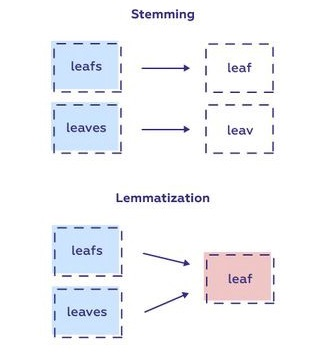

Nous allons également traiter les "Stopwords" qui sont des mots anglais qui n'ont aucune valeur et n'apportes rien au sens d'une phrase.

Par exemple:

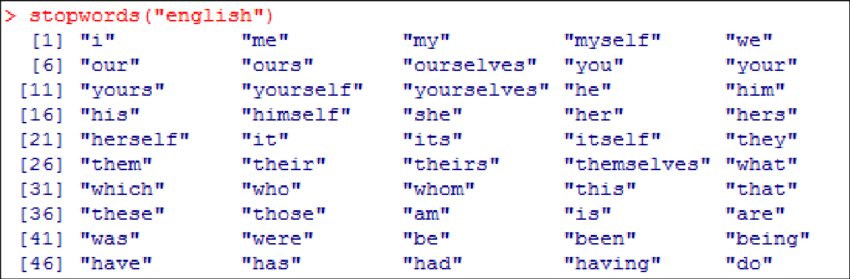

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

re_cleaner = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [11]:
def preprocess(text, stem=False):
  text = re.sub(re_cleaner, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [12]:
Data_set.text = Data_set.text.apply(lambda x: preprocess(x))

Mots **positifs** les plus présents :

In [13]:
#plt.figure(figsize = (20,20)) 
#wc = WordCloud(stopwords = stop_words, max_words = 2000 , width = 1600 , height = 800).generate(" ".join(Data_set[Data_set.sentiment == 'Positive'].text))
#plt.imshow(wc , interpolation = 'bilinear')

Mots **négatifs** les plus présents :

In [14]:
#plt.figure(figsize = (20,20)) 
#wc = WordCloud(stopwords = stop_words, max_words = 2000 , width = 1600 , height = 800).generate(" ".join(Data_set[Data_set.sentiment == 'Negative'].text))
#plt.imshow(wc , interpolation = 'bilinear')

### Entrainement du modèle

In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

Nous allons mélanger notre dataset afin d'avoir un entrainement qualitatif.

In [16]:
train_data, test_data = train_test_split(Data_set, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Partge du dataset en set d'entrainement et de test

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))



Train Data size: 1279999
Test Data size 320000


In [17]:
train_data.head(10)

,sentiment,text
1176709,Positive,lol get coming good way mean way talented authors
641121,Negative,would miss dreaming anymore
1132400,Positive,poletii check following woman ahahha
130866,Negative,im sick thing would make feel better would pal...
1235875,Positive,sounds like cup tea sign
1568154,Positive,think going take hot bath amp listen lvatt
758235,Negative,feel tired today going gym
1446219,Positive,weekend resting peace finally
763239,Negative,sooo jealous hope one day make france go louvr...
584093,Negative,say cry hahah


Nous pouvons donc voir que le dataset d'entrainement est bien mélangé.

### Transformation en Tokens

Le principe de "**Tokenization**" permet de couper une phrase (une séquence de mots (char)) en pièces, appelées "Tokens". Ce processus permet également de se débarasser de certains char tels que les ponctuations, qui nous sont inutiles dans notre cas.

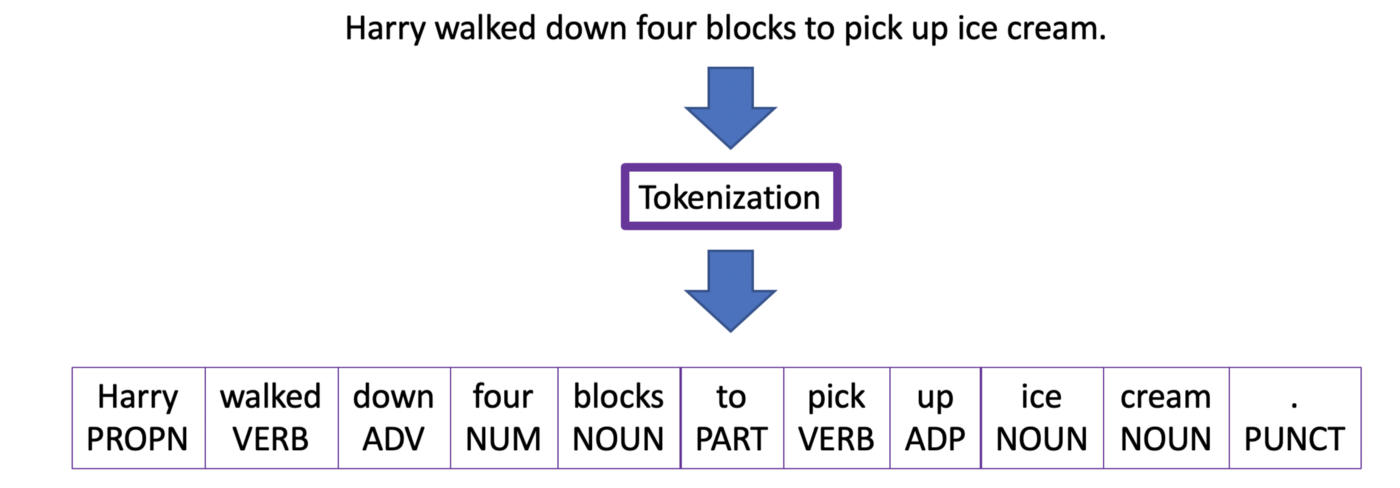

L'objet "tokenizer" créé un token pour chaque mot dans le corpus de donnée et les ajoute dans un dictionnaire.

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ", vocab_size)

Vocab size:  290658


On peut donc maintenant convertir n'importe quel mot en une clé dans le dictionnaire.

On va construire un modèle de séquence. Pour cela, on doit lui fournir une séquence de nombres. Et il faut qu'on fasse attention qu'il n'y ai pas de variance dans la taille des inputs.

Le problème étant que le texte des tweets on pas forcément tous le même nombres de mots. Pour éviter ce problème, on va utiliser *pad_sequence* pour avoir toute les séquences de même taille, MAX_SEQUENCE_LENGHT.



In [19]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

print("xtrain:", type(x_train))
print("xtest:",type(x_test))

Training X Shape: (1279999, 30)
Testing X Shape: (320000, 30)
xtrain: <class 'numpy.ndarray'>
xtest: <class 'numpy.ndarray'>


In [20]:
labels = train_data.sentiment.unique().tolist()

### Encoder les labels

Notre modèle est une classification binaire (0 ou 1, positif ou négatif), il faut donc que nos labels soit sous formes encodés.

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("xtrain:", type(y_train))
print("xtest:",type(y_test))

y_train shape: (1279999, 1)
y_test shape: (320000, 1)
xtrain: <class 'numpy.ndarray'>
xtest: <class 'numpy.ndarray'>


### Embedding des mots

Le principe de "Word Embedding" permet de capturer le context d'un mot selon la phrase dans laquelle il est utilisé, sa sémantique etc...

Dans notre cas, cela va permettre à notre modèle de comprendre plus facilement à quoi correspond chaque mots.

Pour ne pas avoir à entrainer nous même notre système, on va utiliser **Transfer Learning**, ce qui va nous permettre de télécharger un embedding pré-entrainé et l'appliquer à notre modèle.

Nous avons trouvé un Word Embedding pré-entrainé nommé "GloVe" de Stanford AI, et c'est celui que nous allons utilisé.

In [22]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 15

In [23]:
embeddings_index = {}

f = codecs.open(GLOVE_EMB, 'r', encoding='utf-8', errors='ignore')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [24]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print('Embedding matrix:', embedding_matrix)

Embedding matrix: [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.13602    -0.11594    -0.017078   ... -0.33759999  0.070098
   0.24642   ]
 [-0.24501    -0.12491    -0.2536     ... -0.41073    -0.61926001
   0.0039007 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [25]:
weight = torch.FloatTensor(embedding_matrix)
print("weight: ",weight)

weight:  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1360, -0.1159, -0.0171,  ..., -0.3376,  0.0701,  0.2464],
        [-0.2450, -0.1249, -0.2536,  ..., -0.4107, -0.6193,  0.0039],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


## Entrainement du modèle en LSTM

Nous allons utiliser des modèles de séquences puisque le problème principal de notre dataset, comme nous pouvons le voir dans notre nuage de mots, est que certains mots sont prédominants à la fois dans les tweets négatifs, et à la fois dans les tweets positifs.

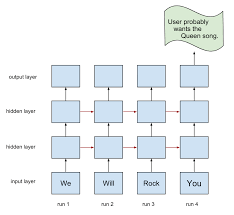

Le réseau de neuronnes va donc sortir une prédiction de valeur scalaire.

Notre modèle aura plusieurs layers:

-L'**Embedding layer** que nous avons déjà créé précédemment. Il va générer un vecteur pour chaque séquence d'entrée.

-Le **LSTM** (Long-Short Term Memory), qui est une variante du RNN et qui possède une mémoire pour apprendre le contexte des mots se trouvant plus loin dans le texte et donc donner du sens contextuel plutot que le faire simplement avec ses voisins.

-Un **Dropout layer**

-Un **Linear layer**

-Un **Sigmoide layer**

In [26]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [27]:
# création de datasets de type tensor
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

# mélange des données
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)



In [28]:
# batch de données d'entrainement
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)
print(sample_x.shape)
print(sample_y.shape)

Sample input size:  torch.Size([1024, 30])
Sample input: 
 tensor([[    0,     0,     0,  ...,   338,    10,    47],
        [    0,     0,     0,  ...,   485,   437, 11545],
        [    0,     0,     0,  ...,    32,    35,    23],
        ...,
        [    0,     0,     0,  ...,  1622,   712,    93],
        [    0,     0,     0,  ...,   559,   314, 23531],
        [    0,     0,     0,  ..., 15925,  2752,   751]], dtype=torch.int32)
Sample input: 
 tensor([[0],
        [1],
        [0],
        ...,
        [1],
        [0],
        [1]], dtype=torch.int32)
torch.Size([1024, 30])
torch.Size([1024, 1])


## Définition du modèle

In [29]:
from unicodedata import bidirectional


class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding.from_pretrained(weight)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True, bidirectional=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim*2, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        BATCH_SIZE = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim*2) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(BATCH_SIZE, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, BATCH_SIZE):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers*2,BATCH_SIZE,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers*2,BATCH_SIZE,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [30]:
no_layers = 2
vocab_size = vocab_size + 1 #extra 1 for padding
output_dim = 1
hidden_dim = 20


model = SentimentRNN(no_layers,vocab_size,hidden_dim,EMBEDDING_DIM,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(290658, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Entrainement et Évaluation du modèle

In [31]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [32]:
clip = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(EPOCHS):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(BATCH_SIZE)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.squeeze().float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(BATCH_SIZE)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.squeeze().float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'ia_dp_logs/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.5083319776243358 val_loss : 0.47784693281237894
train_accuracy : 74.90482414439387 val_accuracy : 76.8009375
Validation loss decreased (inf --> 0.477847).  Saving model ...
Epoch 2
train_loss : 0.472494694425928 val_loss : 0.4653583109760896
train_accuracy : 77.40013859385829 val_accuracy : 77.62125
Validation loss decreased (0.477847 --> 0.465358).  Saving model ...
Epoch 3
train_loss : 0.46321919417266755 val_loss : 0.46081149635406643
train_accuracy : 77.98240467375365 val_accuracy : 77.9225
Validation loss decreased (0.465358 --> 0.460811).  Saving model ...
Epoch 4
train_loss : 0.45758283808767747 val_loss : 0.4572771941431058
train_accuracy : 78.3686549755117 val_accuracy : 78.1459375
Validation loss decreased (0.460811 --> 0.457277).  Saving model ...
Epoch 5
train_loss : 0.45376251111801763 val_loss : 0.4552616961300373
train_accuracy : 78.57740513859777 val_accuracy : 78.23343750000001
Validation loss decreased (0.457277 --> 0.455262).  Saving model ...


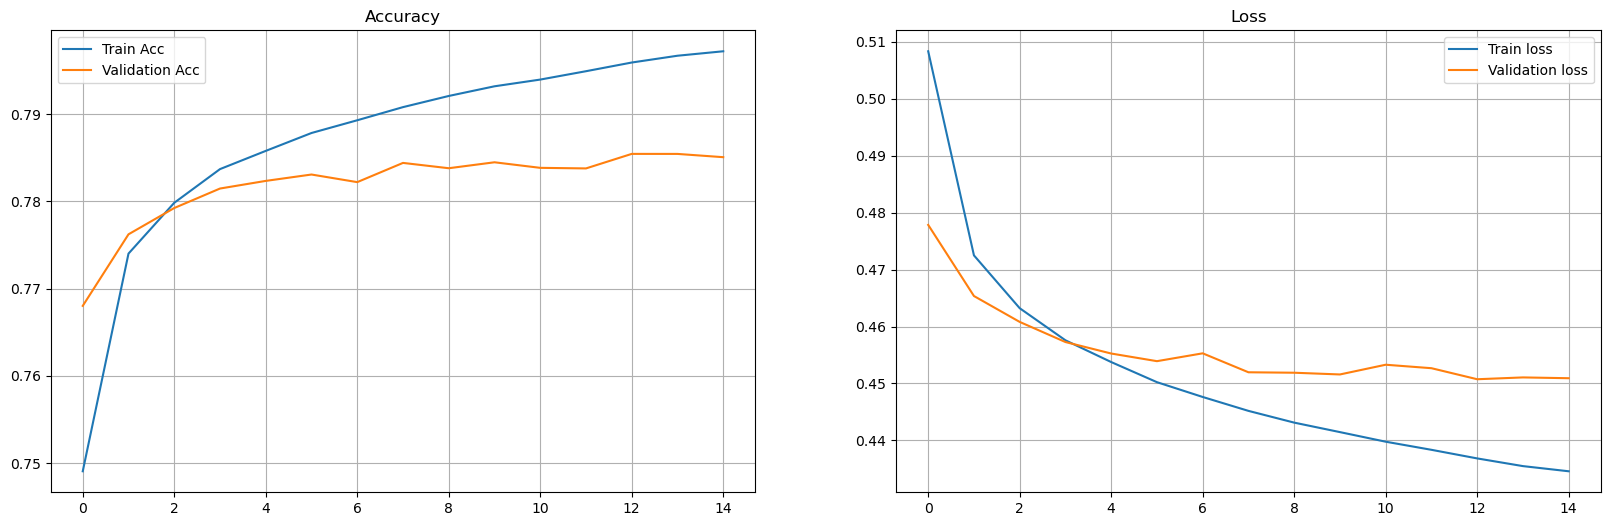

In [33]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()